In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [1]:
from model.resnet import *
from model.effnet import *
from model.unet import *
from utils.metrics import *
from utils.losses import *

import os
import pandas as pd
import warnings
import numpy as np
from skimage import io, transform
from rasterio.features import rasterize
from shapely.ops import cascaded_union, unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import pickle
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses
import copy

from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import timm
from torch.cuda import amp
from tqdm import tqdm
import torch.optim as optim
from time import time

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore")

c:\Users\Yoga 6 R5\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check file or directory is exist
train_df = pd.read_csv("ForestNetDataset/train_new.csv")
val_df = pd.read_csv("ForestNetDataset/val_new.csv")
test_df = pd.read_csv("ForestNetDataset/test_new.csv")

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Grassland shrubland,Grassland shrubland,-1.720266,115.006996,2016,-1.720266384577504_115.00699582064485
1,Grassland shrubland,Grassland shrubland,-2.709149,113.340780,2016,-2.7091489238834305_113.3407801546713
2,Timber plantation,Plantation,-0.652245,109.920619,2012,-0.6522445100247509_109.9206187702712
3,Oil palm plantation,Plantation,-1.347868,110.527867,2014,-1.3478682873694396_110.52786683455288
4,Grassland shrubland,Grassland shrubland,-2.885256,111.584100,2016,-2.8852555512190485_111.5840999668356


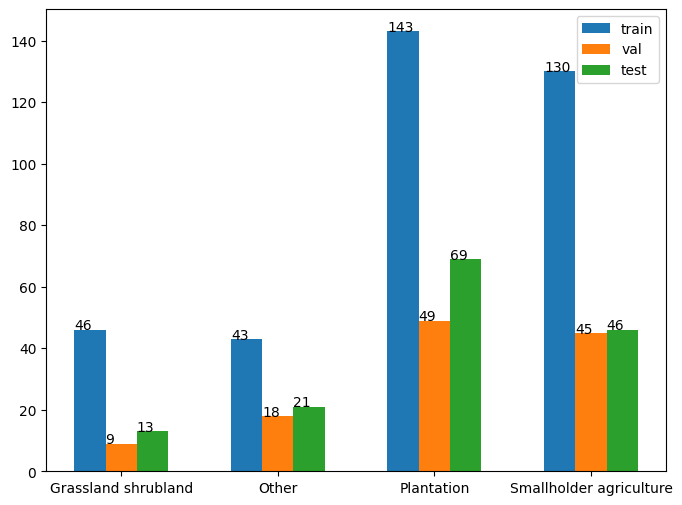

In [4]:
# Plot distribution of data
train_df_class = train_df.groupby(['merged_label']).size().to_frame('train').reset_index()
val_df_class = val_df.groupby(['merged_label']).size().to_frame('val').reset_index()
test_df_class = test_df.groupby(['merged_label']).size().to_frame('test').reset_index()

plt.figure(figsize=(8, 6))
x_axis = np.arange(len(train_df_class['merged_label']))
index = [[train_df_class,'train',-0.2],[val_df_class,'val',0],[test_df_class,'test',0.2]]
for i in index:
  df = i[0]
  bars = plt.bar(x_axis + i[2], df[i[1]] , width=0.2, label=i[1])
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x(), yval + .005, yval)
plt.xticks(x_axis,train_df_class['merged_label'])
plt.legend()
plt.show()

In [3]:
from torch.utils.data import Dataset
import torch
import numpy as np
import os
from skimage import io
from rasterio.features import rasterize
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import pickle


class ForestDataset(Dataset):
    """Forest dataset."""

    def __init__(
        self,
        csv_file_to_df,
        root_dir="ForestNetDataset",
        transform=None,
        types="classifier",
    ):
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_to_int = {
            "Grassland shrubland": 0,
            "Other": 1,
            "Plantation": 2,
            "Smallholder agriculture": 3,
        }
        self.types = types

    def __len__(self):
        return len(self.csv)

    def poly_from_utm(self, polygon):
        poly_pts = []
        if isinstance(polygon, Polygon):
            for i in np.array(polygon.exterior.coords):
                poly_pts.append(tuple(i))
        elif isinstance(polygon, MultiPolygon):
            for p in polygon.geoms:
                for i in np.array(p.exterior.coords):
                    poly_pts.append(tuple(i))
        else:
            raise ValueError(f"Unsupported geometry type: {type(polygon)}")
        return Polygon(poly_pts)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.csv.iloc[idx, 0]
        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        year = self.csv.iloc[idx, 4]
        folder = self.csv.iloc[idx, 5]

        ## Load the image and auxiliary
        image_path = os.path.join(
            self.root_dir, "examples", folder, "images", "visible", "composite.png"
        )
        slope_path = os.path.join(
            self.root_dir, "examples", folder, "auxiliary", "srtm.npy"
        )
        forest_loss_path = os.path.join(
            self.root_dir, "examples", folder, "forest_loss_region.pkl"
        )

        image = io.imread(image_path)
        slope = np.load(slope_path)

        ## Get the segmentation map
        with open(forest_loss_path, "rb") as f:
            data = pickle.load(f)

        nx, ny = 332, 332
        xy_array = np.empty((0, 2))

        if isinstance(data, (Polygon, MultiPolygon)):
            poly_shp = [self.poly_from_utm(data)]
        else:
            poly_shp = [self.poly_from_utm(poly) for poly in data]

        mask = rasterize(shapes=poly_shp, out_shape=(332, 332))
        seg = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        image = torch.from_numpy(image).type(torch.float)
        image = image.permute(2, 0, 1)
        seg = torch.from_numpy(seg).type(torch.uint8)
        slope = torch.from_numpy(slope).type(torch.float)

        merged_label = self.label_to_int[merged_label]

        image = image[:, 86:246, 86:246]
        seg = seg[86:246, 86:246]
        slope = slope[1]
        slope = slope[86:246, 86:246]
        if self.types == "classifier":
            return image, slope, merged_label
        else:
            return image, merged_label

In [4]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(270),
        A.ElasticTransform(
            p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=None
        ),
    ]
)

In [5]:
# Initialization several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
LR = 0.001
EPOCH = 20
nbClass = 4

In [6]:
# Load Dataset and Create DataLoader For Classification
train_dataset = ForestDataset(csv_file_to_df=train_df, transform=transform)
val_dataset = ForestDataset(csv_file_to_df=val_df)
test_dataset = ForestDataset(csv_file_to_df=test_df)  
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

# Load Dataset and Create DataLoader For Representation Learning
train_dataset_re = ForestDataset( csv_file_to_df=train_df, transform=transform, types="projection")
val_dataset_re = ForestDataset( csv_file_to_df=val_df, types="projection")
test_dataset_re = ForestDataset( csv_file_to_df=test_df, types="projection")
trainloader_re = torch.utils.data.DataLoader(train_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
valloader_re = torch.utils.data.DataLoader(val_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
testloader_re = torch.utils.data.DataLoader(test_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
dataloaders_re = {'train': trainloader_re, 'val':valloader_re}

In [7]:
dataiter = iter(trainloader)
images, slope, labels = dataiter.__next__()

print("images shape on PyTroch : ", images.size())
print("slope shape on PyTroch : ", slope.size())
print("labels shape on PyTroch : ", labels.size())

images shape on PyTroch :  torch.Size([16, 3, 160, 160])
slope shape on PyTroch :  torch.Size([16, 160, 160])
labels shape on PyTroch :  torch.Size([16])


In [8]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

In [9]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

# Training

### ResNet Backbone

In [10]:
def train_model_SCL(model, criterion, optimizer, scheduler, num_epochs, dataloaders):
    start = time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    history = defaultdict(list)
    scaler = amp.GradScaler()

    for step, epoch in enumerate(range(1,num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        for phase in ['train','val']:
            if(phase == 'train'):
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            
            for inputs,labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    with amp.autocast(enabled=True):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss = loss / 4
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()

                    if phase == 'train' and (step + 1) % 4 == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        scheduler.step()

                running_loss += loss.item()*inputs.size(0)
            
            epoch_loss = running_loss/dataset_sizes[phase]            
            history[phase + ' loss'].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
            
            # deep copy the model
            if phase=='val' and epoch_loss <= best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    end = time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss ",best_loss)

    model.load_state_dict(best_model_wts)
    return model, history

In [140]:
"""Training Projection Head"""

pretrained_resnet_18 = timm.create_model("resnet18", pretrained=True)
num_ftrs = pretrained_resnet_18.get_classifier().in_features
pretrained_resnet_18.fc = nn.Linear(num_ftrs, 4)
pretrained_resnet_18 = pretrained_resnet_18.to(device)

criterion = SupervisedContrastiveLoss()
optimizer = torch.optim.Adam(pretrained_resnet_18.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, history = train_model_SCL(
    pretrained_resnet_18, criterion, optimizer, scheduler, 20, dataloaders_re
)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Epoch 1/20
----------
train Loss: 0.8444
val Loss: 0.6253
Epoch 2/20
----------
train Loss: 0.8603
val Loss: 0.6389
Epoch 3/20
----------
train Loss: 0.9016
val Loss: 0.6581
Epoch 4/20
----------
train Loss: 0.5895
val Loss: 0.5634
Epoch 5/20
----------
train Loss: 0.5665
val Loss: 0.5634
Epoch 6/20
----------
train Loss: 0.5755
val Loss: 0.5634
Epoch 7/20
----------
train Loss: 0.5736
val Loss: 0.5634
Epoch 8/20
----------
train Loss: 0.5771
val Loss: 0.5635
Epoch 9/20
----------
train Loss: 0.5749
val Loss: 0.5634
Epoch 10/20
----------
train Loss: 0.5832
val Loss: 0.5634
Epoch 11/20
----------
train Loss: 0.5598
val Loss: 0.5634
Epoch 12/20
----------
train Loss: 0.5861
val Loss: 0.5634
Epoch 13/20
----------
train Loss: 0.5880
val Loss: 0.5634
Epoch 14/20
----------
train Loss: 0.5680
val Loss: 0.5634
Epoch 15/20
----------
train Loss: 0.5827
val Loss: 0.5634
Epoch 16/20
----------
train Loss: 0.5810
val Loss: 0.5634
Epoch 17/20
----------
train Loss: 0.5846
val Loss: 0.5634
Epoch 

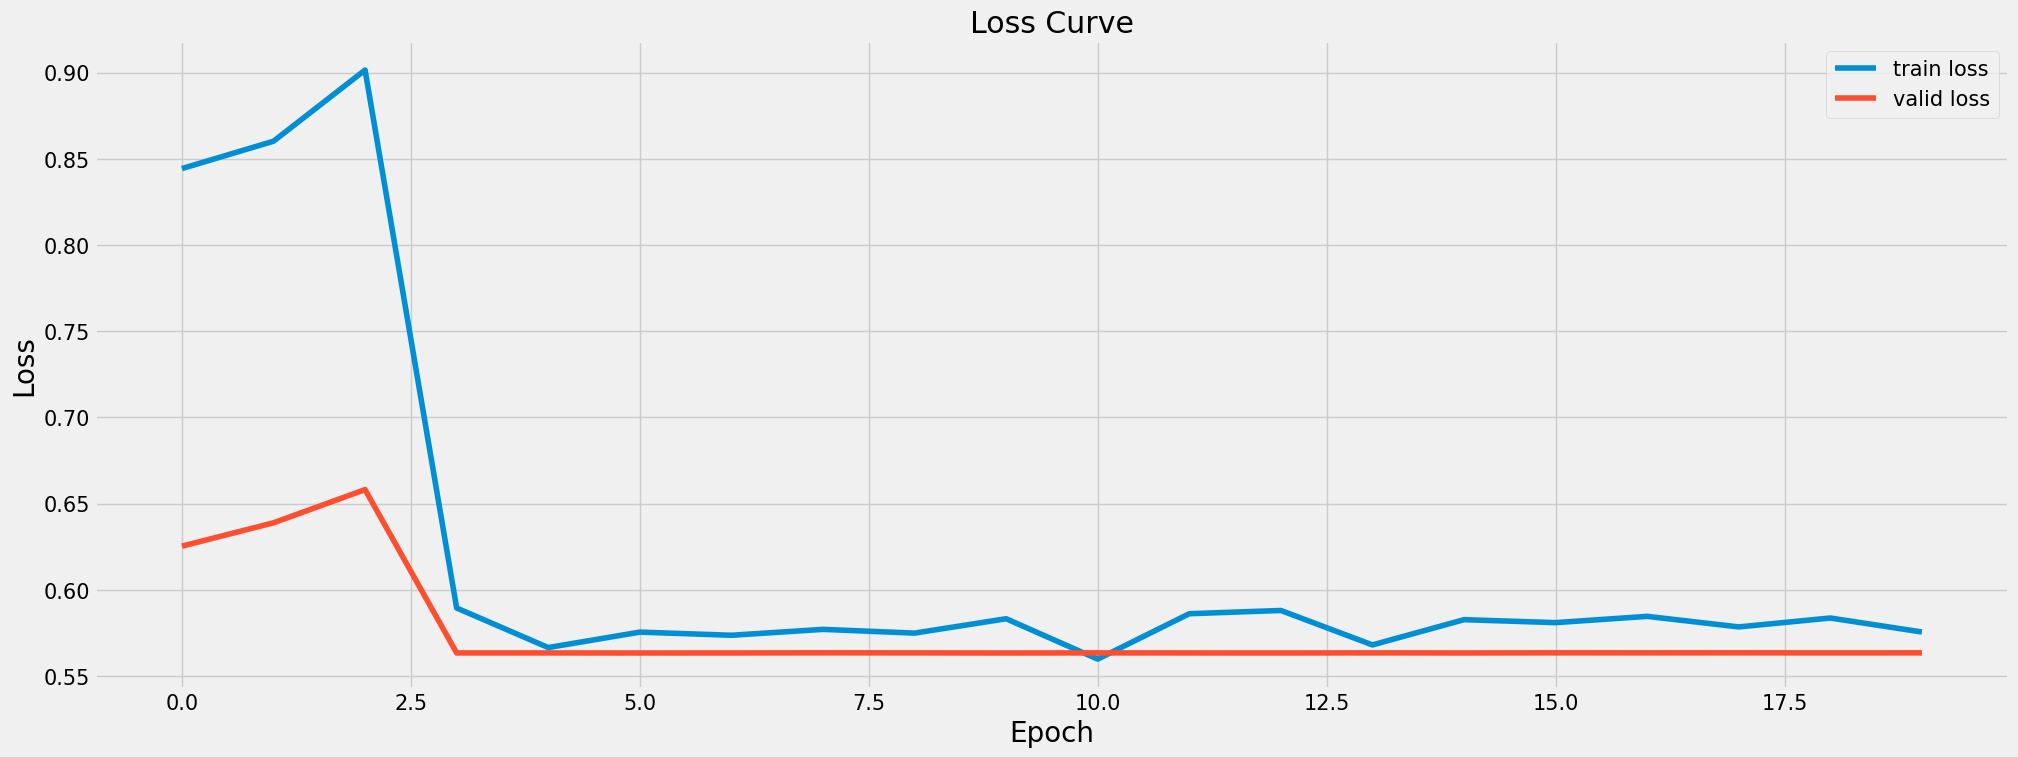

In [141]:
plt.style.use('fivethirtyeight')
plt.rcParams["font.size"] = "15"
fig = plt.figure(figsize=(22,8))
epochs = list(range(20))

plt.plot(epochs, history['train loss'], label='train loss')
plt.plot(epochs, history['val loss'], label='valid loss')
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend()
plt.title('Loss Curve');

In [11]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
    
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for images, slope, labels in dataloaders[phase]:
                images = images.to(device)
                slope = slope.to(device)
                labels = labels.type(torch.LongTensor).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images, slope).to(device)
                    _, preds = torch.max(outputs, 1)
                    preds.to(device)
                    loss = criterion(outputs.to(device), labels.to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            acc_dict[phase].append(epoch_acc)
            loss_dict[phase].append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    
    show_curves(acc_dict, loss_dict)
    model.load_state_dict(best_model_wts)
    
    torch.save(model.state_dict(), 'best_model.pth')
    return model

Epoch 1/15
----------
train Loss: 0.6952 Acc: 0.3729
val Loss: 3.1318 Acc: 0.4215
Epoch 2/15
----------
train Loss: 0.2621 Acc: 0.6796
val Loss: 0.6617 Acc: 0.4215
Epoch 3/15
----------
train Loss: 0.0479 Acc: 0.8923
val Loss: 0.7363 Acc: 0.3388
Epoch 4/15
----------
train Loss: 0.0082 Acc: 0.9669
val Loss: 0.6223 Acc: 0.4215
Epoch 5/15
----------
train Loss: 0.0050 Acc: 0.9834
val Loss: 0.5611 Acc: 0.4050
Epoch 6/15
----------
train Loss: 0.0025 Acc: 0.9834
val Loss: 0.6077 Acc: 0.4298
Epoch 7/15
----------
train Loss: 0.0031 Acc: 0.9862
val Loss: 0.7187 Acc: 0.4132
Epoch 8/15
----------
train Loss: 0.0015 Acc: 0.9862
val Loss: 0.6898 Acc: 0.4215
Epoch 9/15
----------
train Loss: 0.0007 Acc: 0.9917
val Loss: 0.6644 Acc: 0.4132
Epoch 10/15
----------
train Loss: 0.0005 Acc: 0.9945
val Loss: 0.6666 Acc: 0.4132
Epoch 11/15
----------
train Loss: 0.0004 Acc: 1.0000
val Loss: 0.6729 Acc: 0.4132
Epoch 12/15
----------
train Loss: 0.0009 Acc: 0.9945
val Loss: 0.6641 Acc: 0.4380
Epoch 13/15
-

<Figure size 2200x800 with 0 Axes>

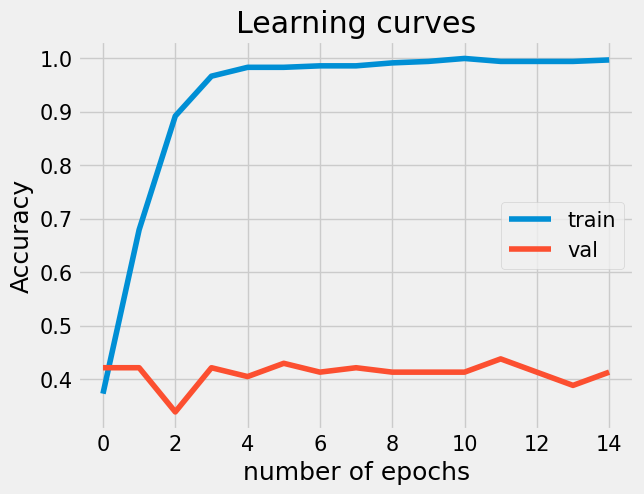

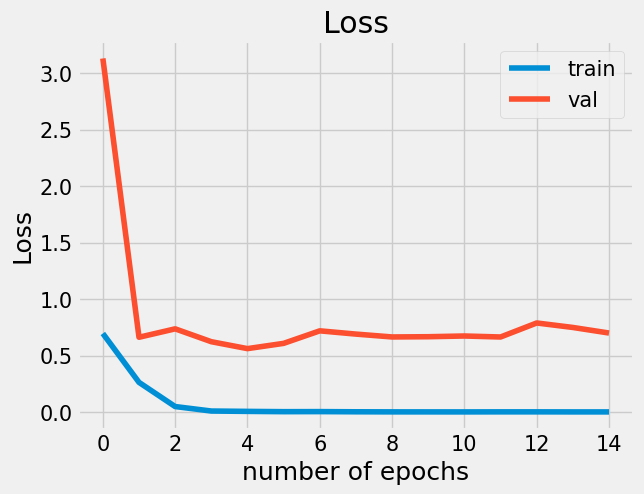

In [144]:
"""Training Resnet Classifier"""

resnet_classifier = resnet18(pretrained=False) 

num_ftrs = resnet_classifier.fc.in_features
resnet_classifier.fc = nn.Linear(
    in_features = num_ftrs, 
    out_features = nbClass
)

resnet_classifier = resnet_classifier.to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(resnet_classifier.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

resnet_classifier = train_model(resnet_classifier, criterion, optimizer, scheduler, num_epochs=15)

torch.save(resnet_classifier.state_dict(), "Trained_Models/ResNet_Model.pth")

In [15]:
def test(model): 
    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for images, slope, labels in testloader: 
            images = images.to(device)
            slope = slope.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            outputs = model(images, slope).to(device)
            _, preds = torch.max(outputs, 1)
            preds.to(device)

            total += labels.size(0) 
            running_accuracy += (preds == labels).sum()
 
        print('Accuracy of the model based on the test set is: %d %%' % (100 * running_accuracy / total))  

In [146]:
test(resnet_classifier)

Accuracy of the model based on the test set is: 49 %


### EfficientNet Backbone

In [12]:
"""Training Projection Head"""
from collections import defaultdict
from time import time

pretrained_eff_b1 = timm.create_model('efficientnet_b2', pretrained=True)
num_ftrs = pretrained_eff_b1.get_classifier().in_features
pretrained_eff_b1.fc = nn.Linear(num_ftrs, 4)
pretrained_eff_b1 = pretrained_eff_b1.to(device)

criterion = SupervisedContrastiveLoss()
optimizer = torch.optim.Adam(pretrained_eff_b1.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model, history = train_model_SCL(pretrained_eff_b1, criterion, optimizer, scheduler, 20, dataloaders_re)

Epoch 1/20
----------
train Loss: 0.7121
val Loss: 0.7528
Epoch 2/20
----------
train Loss: 0.6857
val Loss: 0.6897
Epoch 3/20
----------
train Loss: 0.7336
val Loss: 0.6828
Epoch 4/20
----------
train Loss: 0.5677
val Loss: 0.5514
Epoch 5/20
----------
train Loss: 0.5601
val Loss: 0.5506
Epoch 6/20
----------
train Loss: 0.5470
val Loss: 0.5521
Epoch 7/20
----------
train Loss: 0.5519
val Loss: 0.5531
Epoch 8/20
----------
train Loss: 0.5599
val Loss: 0.5525
Epoch 9/20
----------
train Loss: 0.5643
val Loss: 0.5514
Epoch 10/20
----------
train Loss: 0.5575
val Loss: 0.5521
Epoch 11/20
----------
train Loss: 0.5600
val Loss: 0.5524
Epoch 12/20
----------
train Loss: 0.5451
val Loss: 0.5524
Epoch 13/20
----------
train Loss: 0.5627
val Loss: 0.5530
Epoch 14/20
----------
train Loss: 0.5722
val Loss: 0.5517
Epoch 15/20
----------
train Loss: 0.5650
val Loss: 0.5523
Epoch 16/20
----------
train Loss: 0.5693
val Loss: 0.5510
Epoch 17/20
----------
train Loss: 0.5613
val Loss: 0.5528
Epoch 

Text(0.5, 1.0, 'Loss Curve')

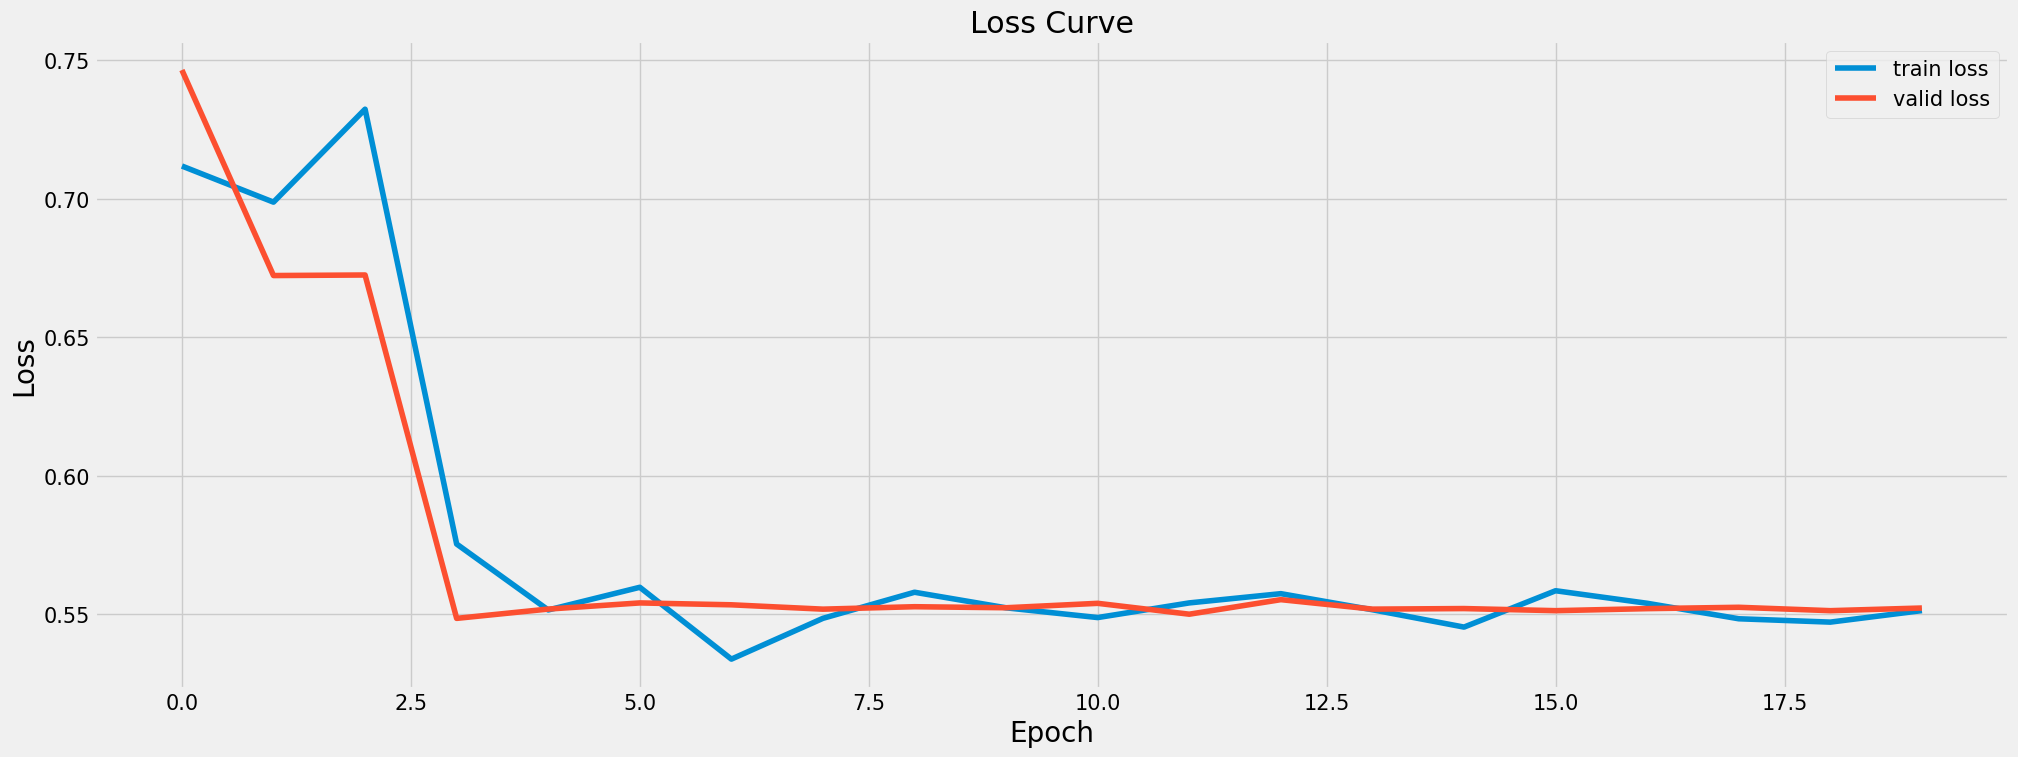

In [148]:
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = "15"
fig = plt.figure(figsize=(22, 8))
epochs = list(range(20))

plt.plot(epochs, history["train loss"], label="train loss")
plt.plot(epochs, history["val loss"], label="valid loss")
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.legend()
plt.title("Loss Curve")

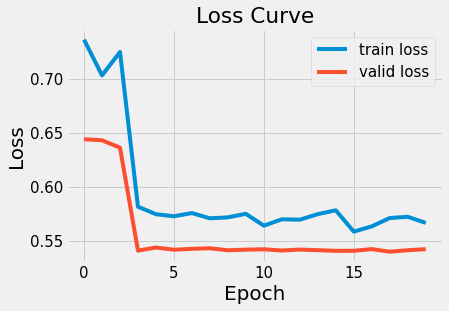

In [22]:
epochs = list(range(20))
plt.plot(epochs, history['train loss'], label='train loss')
plt.plot(epochs, history['val loss'], label='valid loss')
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.legend()
plt.title('Loss Curve');

Loaded pretrained weights for efficientnet-b2
Epoch 1/15
----------
train Loss: 0.6681 Acc: 0.4475
val Loss: 0.9388 Acc: 0.4463
Epoch 2/15
----------
train Loss: 0.1979 Acc: 0.7155
val Loss: 0.6776 Acc: 0.5455
Epoch 3/15
----------
train Loss: 0.0071 Acc: 0.9530
val Loss: 1.2919 Acc: 0.5702
Epoch 4/15
----------
train Loss: 0.0027 Acc: 0.9696
val Loss: 0.9095 Acc: 0.5702
Epoch 5/15
----------
train Loss: 0.0005 Acc: 0.9917
val Loss: 0.7713 Acc: 0.5702
Epoch 6/15
----------
train Loss: 0.0010 Acc: 0.9834
val Loss: 0.7004 Acc: 0.5455
Epoch 7/15
----------
train Loss: 0.0005 Acc: 0.9917
val Loss: 0.5444 Acc: 0.5620
Epoch 8/15
----------
train Loss: 0.0005 Acc: 0.9890
val Loss: 0.5856 Acc: 0.5537
Epoch 9/15
----------
train Loss: 0.0005 Acc: 0.9972
val Loss: 0.5969 Acc: 0.5620
Epoch 10/15
----------
train Loss: 0.0007 Acc: 0.9917
val Loss: 0.5600 Acc: 0.5289
Epoch 11/15
----------
train Loss: 0.0005 Acc: 0.9890
val Loss: 0.5345 Acc: 0.5289
Epoch 12/15
----------
train Loss: 0.0001 Acc: 0.9

<Figure size 2200x800 with 0 Axes>

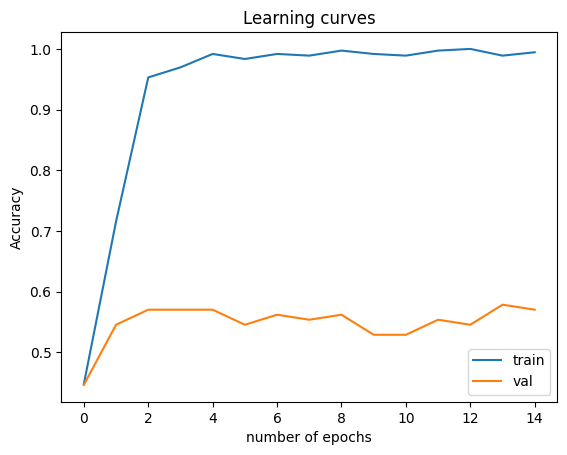

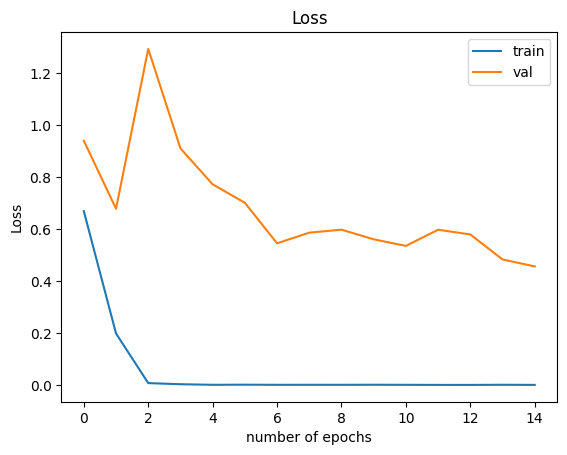

In [13]:
"""EfficientNet B2 Classifier"""

effnet_b2_classifier = effnetb2(pretrained=False)
effnet_b2_classifier = effnet_b2_classifier.to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(effnet_b2_classifier.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

effnet_b2_classifier = train_model(effnet_b2_classifier, criterion, optimizer, scheduler, num_epochs=15)

torch.save(effnet_b2_classifier.state_dict(), "Trained_Models/EfficientNet.pth")

In [16]:
test(effnet_b2_classifier)

Accuracy of the model based on the test set is: 65 %
